<a href="https://colab.research.google.com/github/nhattientran/stackoverflow-classification/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1 : Tiền xử lý dữ liệu

In [5]:
import pandas as pd
data = pd.read_csv("https://github.com/nhattientran/stackoverflow-classification/blob/master/full_dataset_v2.csv?raw=true",delimiter=";")

In [6]:
data.head()

,title,id_stack,tags,views,score,done,label
0,Using entries from other kivy classes,61881920,"['python', 'python-3.x', 'kivy']",12,0,False,python
1,Package python software with pylucene dependency,61896481,"['python', 'docker', 'pip', 'dependencies', 'p...",7,1,False,python
2,Extracting time with regex from a string,61894597,"['python', 'regex']",29,3,False,python
3,How do I add specific headers before each form...,61896721,"['python', 'django']",4,0,False,python
4,Barplot from a dataframe using a column to set...,61896506,"['python', 'pandas', 'bar-chart', 'seaborn', '...",12,0,True,python


In [7]:
data.tail()

,title,id_stack,tags,views,score,done,label
52000,return not working on JS but console.log does,62259432,['javascript'],17,-3,False,javascript
52001,How to clear data of AutoComplete Box using On...,61701206,"['javascript', 'reactjs', 'react-native', 'mat...",46,1,True,javascript
52002,Facade\Ignition\Exceptions\ViewException Tryin...,62259467,"['php', 'laravel']",2,0,False,php
52003,Install git on vim for php development,62259442,"['php', 'git', 'vim', 'bitbucket', 'web-deploy...",2,0,False,php
52004,Creating custom widget in wordpress,62259409,"['php', 'wordpress']",4,0,False,php


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52005 entries, 0 to 52004
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     52005 non-null  object
 1   id_stack  52005 non-null  int64 
 2   tags      52005 non-null  object
 3   views     52005 non-null  int64 
 4   score     52005 non-null  int64 
 5   done      52005 non-null  bool  
 6   label     52005 non-null  object
dtypes: bool(1), int64(3), object(3)
memory usage: 2.4+ MB


In [9]:
data.shape

(52005, 7)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


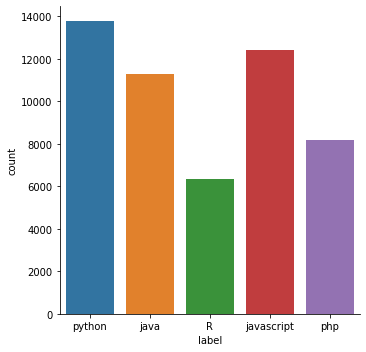

In [10]:
import seaborn as sns
sns.catplot(x="label",kind="count",data=data)

In [11]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
X = data['title']
Y = pd.get_dummies(data['label'])

In [13]:
def preprocessor(review):
  review=re.sub('<[^>]*>', '', review)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',review)
  review = (re.sub('[\W]+', ' ', review.lower()) +' '.join(emoticons).replace('-', ''))
  review = review.split()
  ps = PorterStemmer()
  review = [ps.stem(word) for word in review if word not in stopwords.words("english")]
  review = " ".join(review)
  return review
X = X.apply(preprocessor)

Word2Vec

In [14]:
import gensim
sent = ([row.split() for row in X])
w2v = gensim.models.Word2Vec(
        sent,
        size=300,
        window=10,
        min_count=2,
        workers=10,
        iter=10)

In [16]:
import numpy as np
embedding_matrix = np.zeros((len(w2v.wv.vocab) + 1, 300))
for i, vec in enumerate(w2v.wv.vectors):
  embedding_matrix[i] = vec

In [17]:
embedding_matrix.shape

(8022, 300)

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=len(w2v.wv.vocab)+1)
tokenizer.fit_on_texts(data['title'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22467 unique tokens.


In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(data['title'].values)
X = pad_sequences(X)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (52005, 37)


Train_test_split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,train_size=0.8,random_state=0) 

#2 : Huấn luyện mô hình

LSTM

In [22]:
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
model = keras.Sequential()
model.add(layers.Embedding(len(w2v.wv.vocab)+1,300,input_length=X.shape[1],weights=[embedding_matrix]))
model.add(layers.LSTM(300))
model.add(layers.Dense(Y.shape[1],activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 37, 300)           2406600   
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 5)                 1505      
Total params: 3,129,305
Trainable params: 3,129,305
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [41]:
batch = 64
model.fit(X_train,Y_train,batch_size = batch ,epochs=1)

651/651 [==============================] - 12s 18ms/step - loss: 5.6917e-04 - accuracy: 0.9997


#3 : Đánh giá mô hình

In [42]:
model.evaluate(X_test,Y_test)

326/326 [==============================] - 1s 4ms/step - loss: 2.5048 - accuracy: 0.7990


[2.504790782928467, 0.7989616394042969]

#4 : Lưu mô hình

In [ ]:
import joblib
joblib.dump(model,'model.pkl')